In [1]:
# Cell 1: Import required libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from datetime import datetime

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [2]:
# Cell 2: Initialize TPU and set up strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None
    print('Not connected to a TPU runtime')

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS:", strategy.num_replicas_in_sync)


Running on TPU: 
REPLICAS: 8


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Create a local directory to store your dataset in Colab
!mkdir /content/local_data

# Path to your data in Google Drive
google_drive_data_path = '/content/drive/My Drive/ML_Data/final_dataset_split.zip'  # Note the trailing slash

# Local path where you want to store the copied data
local_data_path = '/content/local_data/'  # Copy into a "resized" folder inside local_data

# Use rsync for faster copying of data
!rsync -avh --progress "$google_drive_data_path" "$local_data_path"


# Define the path to the zip file
zip_file_path = '/content/local_data/final_dataset_split.zip'

# Define the extraction path
extracted_data_path = '/content/local_data'

# Unzip the file
!unzip -q {zip_file_path} -d {extracted_data_path}

# List the files to verify
!ls {extracted_data_path}


Mounted at /content/drive
sending incremental file list
final_dataset_split.zip
        758.43M 100%  105.69MB/s    0:00:06 (xfr#1, to-chk=0/1)

sent 758.62M bytes  received 35 bytes  79.85M bytes/sec
total size is 758.43M  speedup is 1.00
final_dataset_split  final_dataset_split.zip


In [4]:
# Cell 3: Define dataset paths and data loaders

MODEL_SAVE_PATH = "/content/drive/My Drive/ML_Data/saved_model/triangle/"
DATASET_BASE_PATH = '/content/local_data/final_dataset_split'
# DATASET_BASE_PATH = 'gs://mudassar_dataset/final_dataset_split'

print(f"Model save path: {MODEL_SAVE_PATH}")
print(f"Dataset base path: {DATASET_BASE_PATH}")

Model save path: /content/drive/My Drive/ML_Data/saved_model/triangle/
Dataset base path: /content/local_data/final_dataset_split


In [5]:
# Cell 4: Load data using tf.data.Dataset
def load_data():
    BATCH_SIZE = 128 * strategy.num_replicas_in_sync  # Adjust as needed
    IMG_SIZE = (224, 224)

    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_BASE_PATH, 'train'),
        labels='inferred',
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True
    )

    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_BASE_PATH, 'val'),
        labels='inferred',
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=False
    )

    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_BASE_PATH, 'test'),
        labels='inferred',
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=False
    )

    return train_dataset, validation_dataset, test_dataset

In [6]:
# Cell 5: Load data and output number of images in each set
train_dataset, validation_dataset, test_dataset = load_data()

# Get class names and number of classes
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

# Output number of images in each dataset
train_image_count = sum([len(files) for r, d, files in os.walk(os.path.join(DATASET_BASE_PATH, 'train'))])
val_image_count = sum([len(files) for r, d, files in os.walk(os.path.join(DATASET_BASE_PATH, 'val'))])
test_image_count = sum([len(files) for r, d, files in os.walk(os.path.join(DATASET_BASE_PATH, 'test'))])

print(f"Number of training images: {train_image_count}")
print(f"Number of validation images: {val_image_count}")
print(f"Number of test images: {test_image_count}")


Found 40270 files belonging to 3 classes.
Found 8628 files belonging to 3 classes.
Found 8632 files belonging to 3 classes.
Class names: ['hc', 'pd', 'prodromal']
Number of classes: 3
Number of training images: 40270
Number of validation images: 8629
Number of test images: 8632


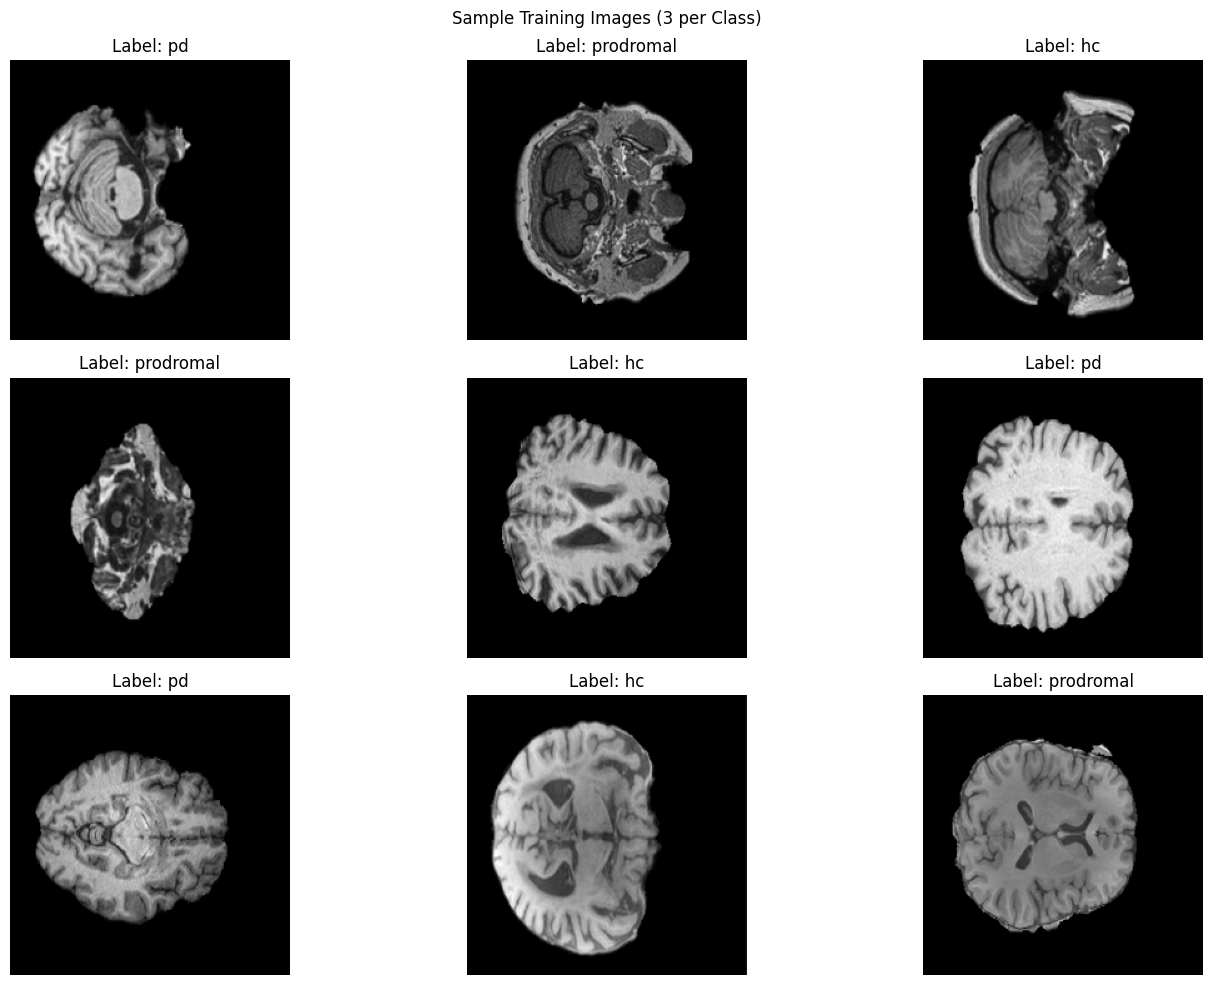

In [7]:
# Cell 6: Data verification - Display 9 images
def display_sample_images(dataset, class_names):
    plt.figure(figsize=(15, 10))
    for images, labels in dataset.take(1):
        class_counts = {i: 0 for i in range(num_classes)}
        images_displayed = 0
        for idx in range(len(images)):
            class_idx = tf.argmax(labels[idx]).numpy()
            if class_counts[class_idx] < 3:
                plt.subplot(3, 3, images_displayed + 1)
                plt.imshow(images[idx].numpy().astype("uint8"))
                plt.title(f"Label: {class_names[class_idx]}")
                plt.axis('off')
                class_counts[class_idx] += 1
                images_displayed += 1
            if images_displayed == 9:
                break
    plt.suptitle('Sample Training Images (3 per Class)')
    plt.tight_layout()
    plt.show()

display_sample_images(train_dataset, class_names)

In [16]:
# Cell 7: Build the Model with a Triangular Layer Structure
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import tensorflow as tf

# Regularization factor
regularization = l2(0.0001)

with strategy.scope():
    # Load the base model with ImageNet weights, excluding the top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    # Add Global Average Pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # First half of the triangular pattern (Increasing the size)
    x = Dense(256, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.2)(x)  # Shallow layer dropout

    x = Dense(512, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.25)(x)

    x = Dense(1024, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.3)(x)

    x = Dense(2048, activation='relu', kernel_regularizer=regularization)(x)  # Peak of the triangle
    x = Dropout(0.4)(x)

    # Second half of the triangular pattern (Decreasing the size)
    x = Dense(2048, activation='relu', kernel_regularizer=regularization)(x)  # Still at the peak
    x = Dropout(0.4)(x)

    x = Dense(1024, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.3)(x)

    x = Dense(512, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.25)(x)

    x = Dense(256, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.2)(x)

    # Output layer for classification
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Create the complete model
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile the model with Adam optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',                   # Track accuracy
            tf.keras.metrics.Precision(),  # Precision metric
            tf.keras.metrics.Recall(),     # Recall metric
            tf.keras.metrics.AUC(name='auc')  # AUC metric for overall performance
        ]
    )

    # Display the model summary
    model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [17]:
# Cell 8:  training of model   Target For 80%   changed from le5 to le4

EPOCHS = 100  # Define the number of epochs

# Wrap training and saving within the TPU strategy scope
with strategy.scope():
    # Train the model with the LR callback
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=EPOCHS,
#         callbacks=[lr_callback],  # Pass the LR callback here
        verbose=2  # Display progress with a progress bar
    )

    # Save the model with a timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_save_path_with_timestamp = os.path.join(MODEL_SAVE_PATH, f"resnet50_model_{timestamp}.h5")

    # Save the model without wrapping in tf.device
    model.save(model_save_path_with_timestamp)
    print(f"Model saved to: {model_save_path_with_timestamp}")


Epoch 1/100
40/40 - 77s - loss: 1.8249 - accuracy: 0.3480 - precision_1: 0.3166 - recall_1: 0.0025 - auc: 0.5166 - val_loss: 1.8034 - val_accuracy: 0.4215 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc: 0.6056 - 77s/epoch - 2s/step
Epoch 2/100
40/40 - 31s - loss: 1.7830 - accuracy: 0.4058 - precision_1: 0.5329 - recall_1: 0.0191 - auc: 0.5883 - val_loss: 1.7096 - val_accuracy: 0.5019 - val_precision_1: 0.5913 - val_recall_1: 0.1280 - val_auc: 0.6816 - 31s/epoch - 781ms/step
Epoch 3/100
40/40 - 30s - loss: 1.6937 - accuracy: 0.4893 - precision_1: 0.5549 - recall_1: 0.2140 - auc: 0.6821 - val_loss: 1.6216 - val_accuracy: 0.5378 - val_precision_1: 0.6204 - val_recall_1: 0.3112 - val_auc: 0.7375 - 30s/epoch - 752ms/step
Epoch 4/100
40/40 - 30s - loss: 1.6138 - accuracy: 0.5391 - precision_1: 0.5965 - recall_1: 0.3481 - auc: 0.7348 - val_loss: 1.5522 - val_accuracy: 0.5707 - val_precision_1: 0.6488 - val_recall_1: 0.3873 - val_auc: 0.7731 - 30s/epoch - 745ms/step
Epoch 5

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to: /content/drive/My Drive/ML_Data/saved_model/triangle/resnet50_model_20241016_181516.h5


Training history plot saved to: /content/training_history.png


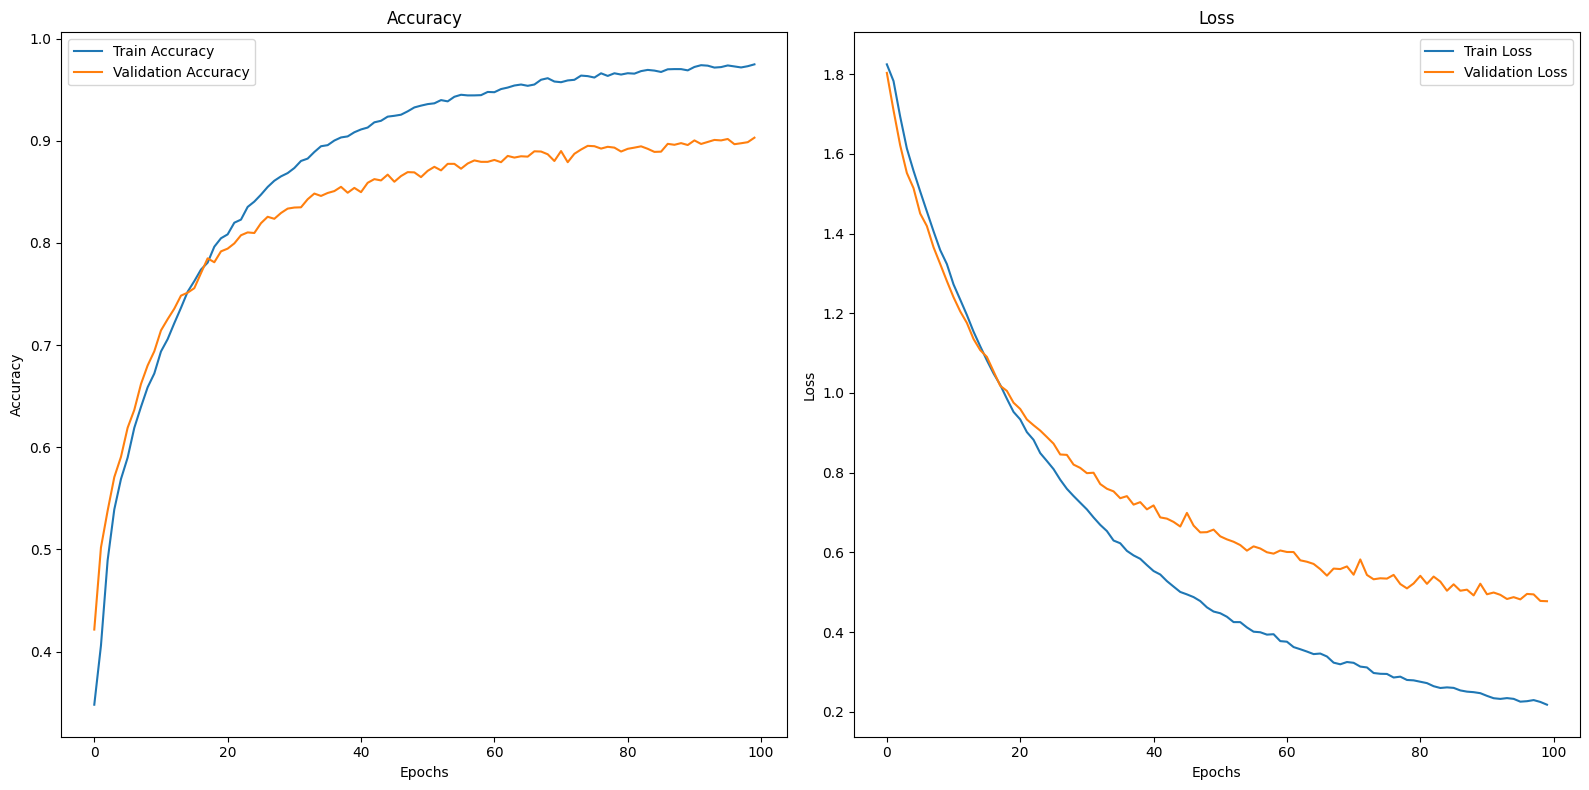

In [18]:
# Cell 9: Plot training history
def plot_training_history(history):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    # Save the figure as a PNG in the /content directory
    plt.tight_layout()
    plt.savefig('/content/training_history.png', format='png')  # Explicitly save as PNG
    print('Training history plot saved to: /content/training_history.png')


plot_training_history(history)

9/9 [==============================] - 32s 3s/step
Confusion matrix plot saved to: plots/confusion_matrix.png


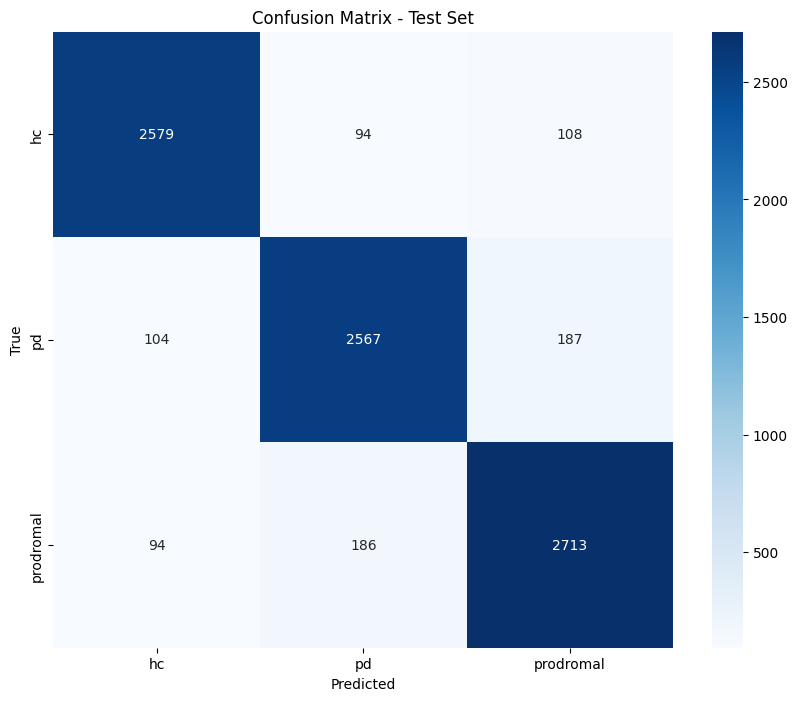

Classification Report:
              precision    recall  f1-score   support

          hc       0.93      0.93      0.93      2781
          pd       0.90      0.90      0.90      2858
   prodromal       0.90      0.91      0.90      2993

    accuracy                           0.91      8632
   macro avg       0.91      0.91      0.91      8632
weighted avg       0.91      0.91      0.91      8632

Test Accuracy: 0.9104
Test F1 Score (Weighted): 0.9105
Test Precision (Weighted): 0.9105
Test Recall (Weighted): 0.9104
9/9 [==============================] - 7s 484ms/step
ROC curve plot saved to: plots/roc_curve.png


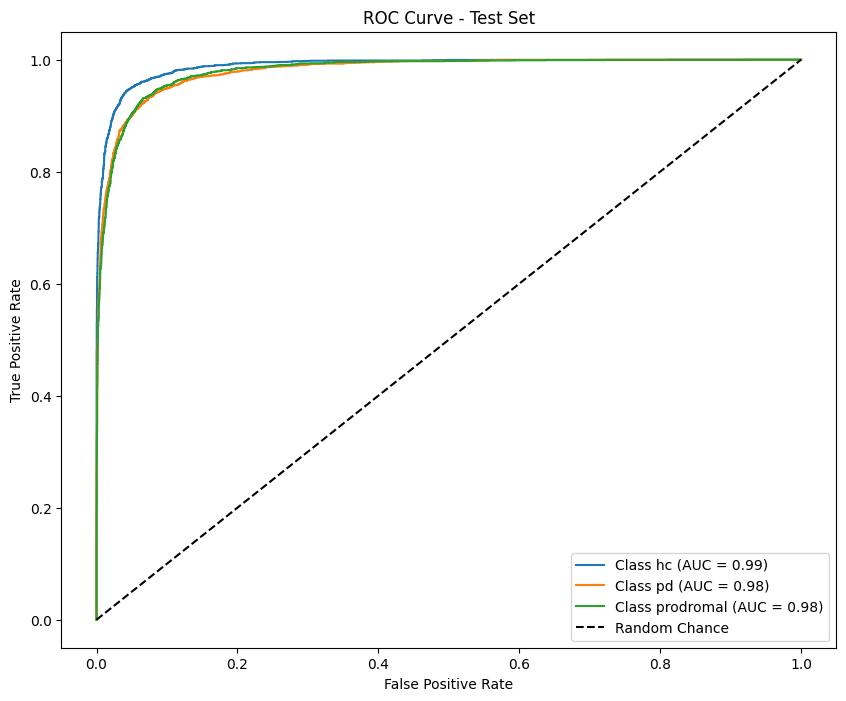

In [19]:
# Cell 10: Generate predictions and classification report, ROC curve, and other metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

# Define function to evaluate the model
def evaluate_model_on_test_data(model, test_dataset, class_names):
    # Generate predictions on the test dataset
    y_pred = np.argmax(model.predict(test_dataset), axis=1)

    # Extract true labels from the dataset
    y_true = []
    for images, labels in test_dataset:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_true = np.array(y_true)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.title('Confusion Matrix - Test Set')

    # Save confusion matrix plot
    plot_save_dir = "plots/"
    if not os.path.exists(plot_save_dir):
        os.makedirs(plot_save_dir)
    confusion_matrix_plot_path = os.path.join(plot_save_dir, 'confusion_matrix.png')
    plt.savefig(confusion_matrix_plot_path)
    print(f"Confusion matrix plot saved to: {confusion_matrix_plot_path}")
    plt.show()

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(f"Classification Report:\n{report}")

    # F1, Precision, Recall, Accuracy
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (Weighted): {f1:.4f}")
    print(f"Test Precision (Weighted): {precision:.4f}")
    print(f"Test Recall (Weighted): {recall:.4f}")

    # ROC Curve and AUC Score for each class
    y_prob = model.predict(test_dataset)
    plt.figure(figsize=(10, 8))

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true == i, y_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc_score(y_true == i, y_prob[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Test Set')
    plt.legend()

    # Save ROC plot
    roc_plot_path = os.path.join(plot_save_dir, 'roc_curve.png')
    plt.savefig(roc_plot_path)
    print(f"ROC curve plot saved to: {roc_plot_path}")
    plt.show()

# Call the evaluation function
evaluate_model_on_test_data(model, test_dataset, class_names)
